# Multimodal approach using both RAW EEG Features & Spectrograms


#### Overall pipeline in this notebook is somewhat like this.
![img2](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F4712534%2Fc4e39641fa8ec13588b62065ae1e9b58%2FScreenshot%202024-02-10%20at%2010.40.36%20PM.png?generation=1707585942607444&alt=media)

In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from sklearn.model_selection import GroupKFold
from utils.config import Config
from utils.loss import KLDivLossWithLogits, CrossEntropyLossWithLogits
from utils.grad_cam import get_grad_cam
from eeg_dataset import EEGDataset, EEGSpecDataset, EEGWaveDataset, get_fold_dls
from exp import Experiment, KFoldModels, predict_helper


/Users/haoyang/miniconda3/envs/umich/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import random

seed = Config.seed

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.set_float32_matmul_precision('high')
torch.use_deterministic_algorithms(True, warn_only=True)
pl.seed_everything(seed, workers=True)

Seed set to 42


42

### Load the data

In [3]:
"""The main function to run the experiment."""
# Load the data
df = pd.read_csv(f'{Config.data_root}train_300_patients.csv')
# EEG_IDS = df.eeg_id.unique()
TARGETS = Config.TARGETS
# TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
# TARS_INV = {x:y for y,x in TARS.items()}

train_df = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_id':'first',
    'spectrogram_label_offset_seconds':'min'
})
train_df.columns = ['spectogram_id','min']

aux = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_label_offset_seconds':'max'
})
train_df['max'] = aux

aux = df.groupby('eeg_id')[['patient_id']].agg('first')
train_df['patient_id'] = aux

aux = df.groupby('eeg_id')[TARGETS].agg('sum')
for label in TARGETS:
    train_df[label] = aux[label].values

y_data = train_df[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[TARGETS] = y_data
aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux
train = train_df.reset_index()
all_spectrograms = np.load(Config.PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()
all_eegs = np.load(Config.PRE_LOADED_EEGS, allow_pickle=True).item()

### Reload the EEGWaveNet and EEGSpecNet model

In [4]:
import torch
torch.set_float32_matmul_precision('high')

In [5]:
Config.output_dir = "results/output"
Config.backbone_2d = "tf_efficientnet_b1"
Config.trn_folds = [0, 1, 2]

In [6]:
from exp import KFoldModels

model = KFoldModels(Config, "EEGModel")

1280
1280
1280


### Draw function

In [7]:
fold = 2

In [8]:
oof_path = "results/output/oof.csv"

# oof_path = f"results_cmp/output/EEGModel_pred_df_f{fold}.csv"
oof = pd.read_csv(oof_path)
columns = ['pred_' + col for col in TARGETS]
oof["pred_target"] = oof[columns].values.argmax(axis=1)
oof.head()

eeg_id  spectogram_id     min     max  patient_id  seizure_vote  lpd_vote  \
0  568657      789577333     0.0    16.0       20654           0.0  0.000000   
1  582999     1552638400     0.0    38.0       20230           0.0  0.857143   
2  642382       14960202  1008.0  1032.0        5955           0.0  0.000000   
3  751790      618728447   908.0   908.0       38549           0.0  0.000000   
4  778705       52296320     0.0     0.0       40955           0.0  0.000000   

   gpd_vote  lrda_vote  grda_vote  other_vote target  fold  pred_seizure_vote  \
0      0.25   0.000000   0.166667    0.583333  Other     4           0.265079   
1      0.00   0.071429   0.000000    0.071429    LPD     1           0.026400   
2      0.00   0.000000   0.000000    1.000000  Other     4           0.006337   
3      1.00   0.000000   0.000000    0.000000    GPD     2           0.019391   
4      0.00   0.000000   0.000000    1.000000  Other     0           0.051985   

   pred_lpd_vote  pred_gpd_vote  pred_lrda_vote  pred_grda_vote  \
0       0.025570       0.053241        0.035806        0.060268   
1       0.275903       0.008312        0.063844        0.014947   
2       0.008682       0.007709        0.033522        0.232247   
3       0.693066       0.202549        0.005919        0.004818   
4       0.043829       0.093049        0.094969        0.263551   

   pred_other_vote  pred_target  
0         0.560036            5  
1         0.610594            5  
2         0.711503            5  
3         0.074257            1  
4         0.452617            5

In [9]:
oof.shape

(17089, 20)

In [10]:
name_mapping = {"Seizure":0, "LPD":1, "GPD":2, "LRDA":3, "GRDA":4, "Other":5}
name_mapping_inv = {v:k for k,v in name_mapping.items()}

In [11]:
import os
if not os.path.exists("figures"):
    os.makedirs("figures")


#########################
### SEIZURE_VOTE
#########################
Found 345/526 samples (0.656) in fold zero OOF for seizure_vote with true>0.5


eeg_id  spectogram_id  min   max  patient_id  seizure_vote  lpd_vote  \
81  148744122      497119908  0.0  80.0       37447      0.971429       0.0   

    gpd_vote  lrda_vote  grda_vote  other_vote   target  
81       0.0        0.0        0.0    0.028571  Seizure

Begin grad cam

#########################


#########################
### LPD_VOTE
#########################
Found 148/290 samples (0.510) in fold zero OOF for lpd_vote with true>0.5


eeg_id  spectogram_id  min   max  patient_id  seizure_vote  lpd_vote  \
38  58250950     1111830885  0.0  28.0       55705           0.0  0.769231   

    gpd_vote  lrda_vote  grda_vote  other_vote target  
38  0.076923        0.0   0.076923    0.076923    LPD

Begin grad cam

#########################


#########################
### GPD_VOTE
#########################
Found 152/313 samples (0.486) in fold zero OOF for gpd_vote with true>0.5


eeg_id  spectogram_id     min     max  patient_id  seizure_vote  \
97  181683828      692011718  1162.0  1162.0       61621           0.0   

    lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote target  
97       0.0       1.0        0.0        0.0         0.0    GPD

Begin grad cam

#########################


#########################
### LRDA_VOTE
#########################
Found 14/127 samples (0.110) in fold zero OOF for lrda_vote with true>0.5


eeg_id  spectogram_id    min    max  patient_id  seizure_vote  \
83  150782229     1248146788  514.0  562.0       31386           0.0   

    lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote target  
83       0.0       0.0   0.533333   0.333333    0.133333   LRDA

Begin grad cam

#########################


#########################
### GRDA_VOTE
#########################
Found 183/291 samples (0.629) in fold zero OOF for grda_vote with true>0.5


eeg_id  spectogram_id  min   max  patient_id  seizure_vote  lpd_vote  \
42  67220444     1263796572  0.0  54.0       35139           0.0       0.0   

    gpd_vote  lrda_vote  grda_vote  other_vote target  
42       0.0        0.0        1.0         0.0   GRDA

Begin grad cam

#########################


#########################
### OTHER_VOTE
#########################
Found 1292/1569 samples (0.823) in fold zero OOF for other_vote with true>0.5


eeg_id  spectogram_id    min    max  patient_id  seizure_vote  lpd_vote  \
2  5586700      619167662  270.0  270.0       20547           0.0       0.0   

   gpd_vote  lrda_vote  grda_vote  other_vote target  
2       0.0        0.0        0.0         1.0  Other

Begin grad cam

#########################



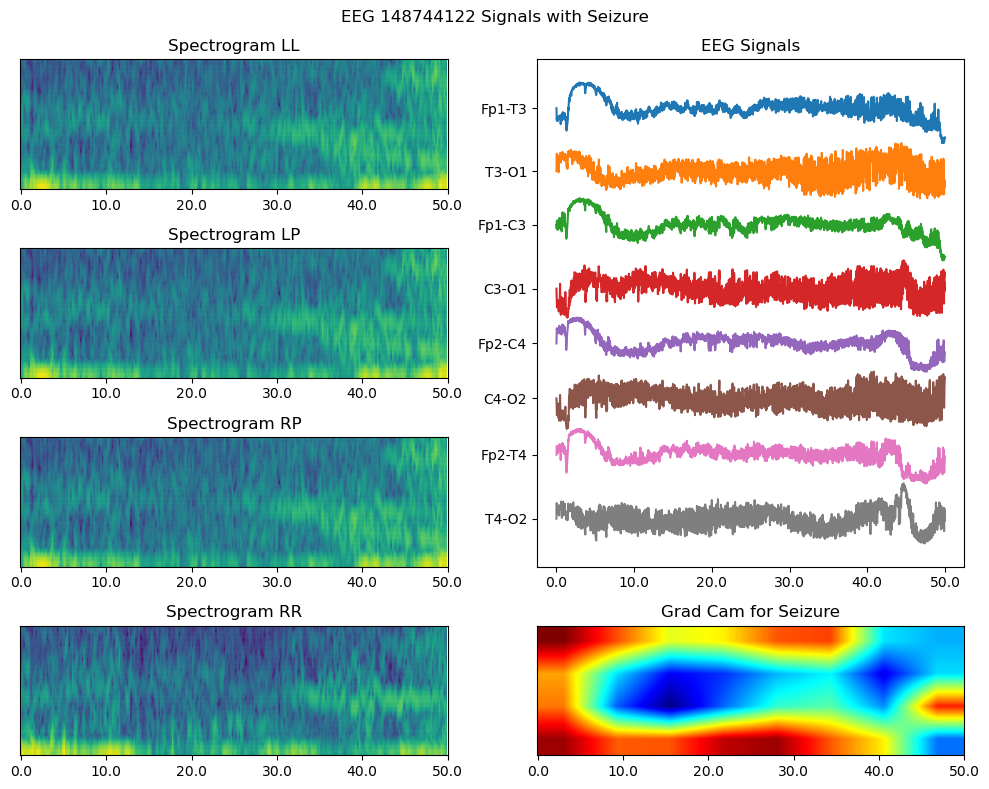

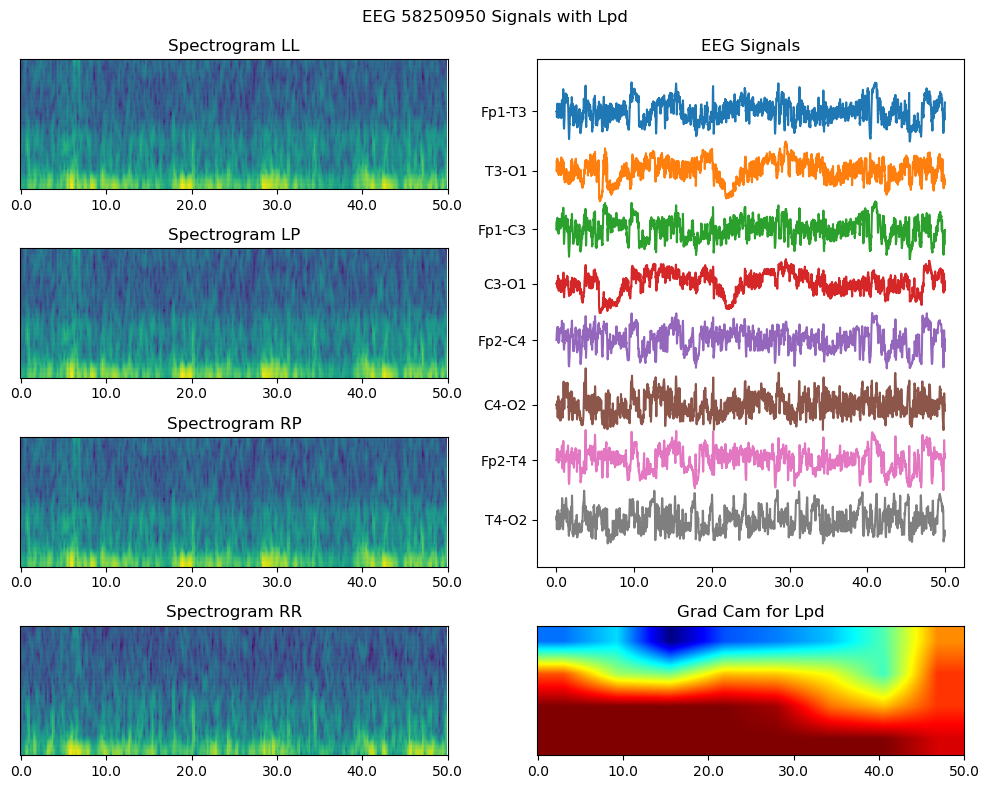

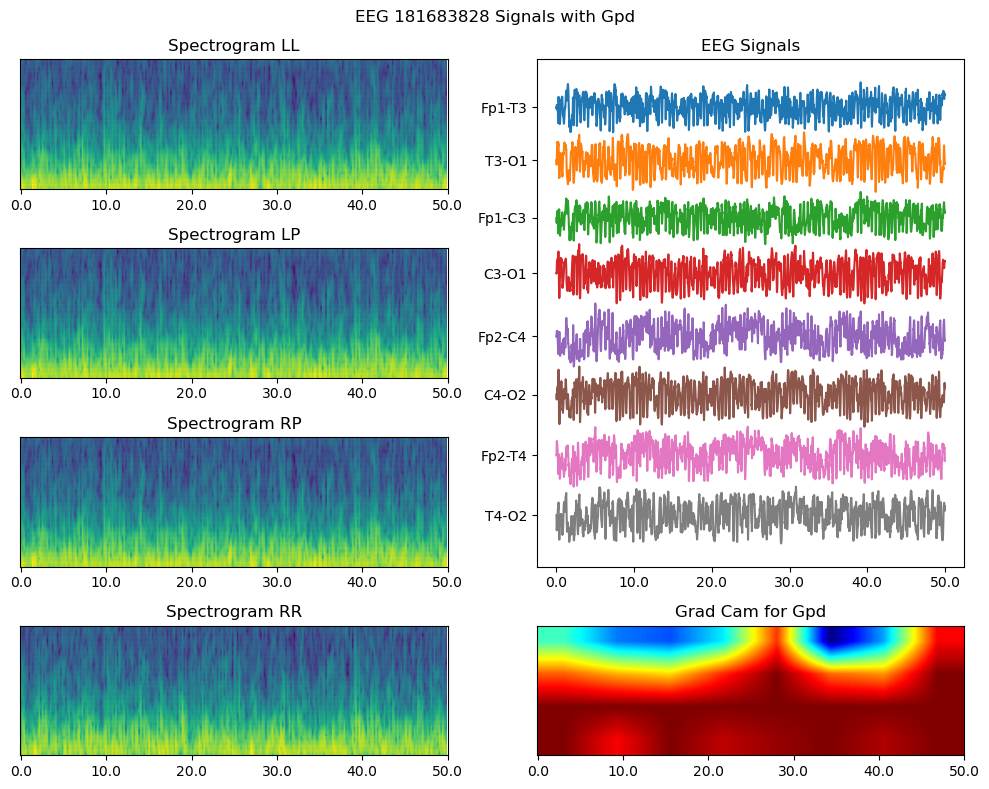

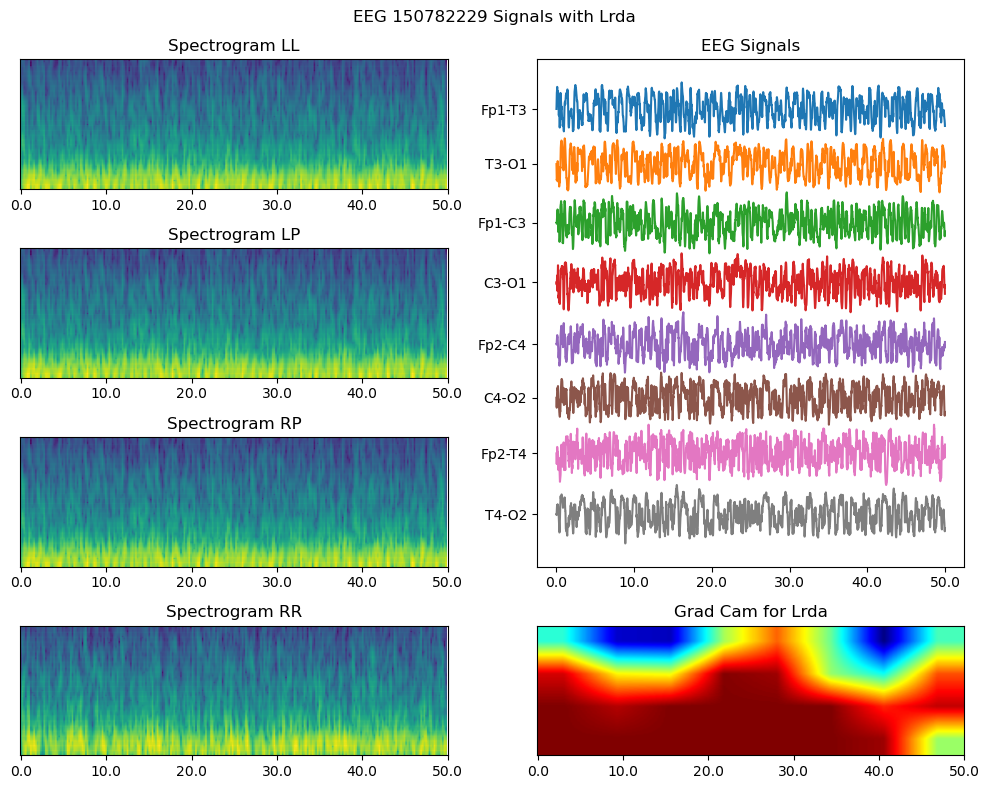

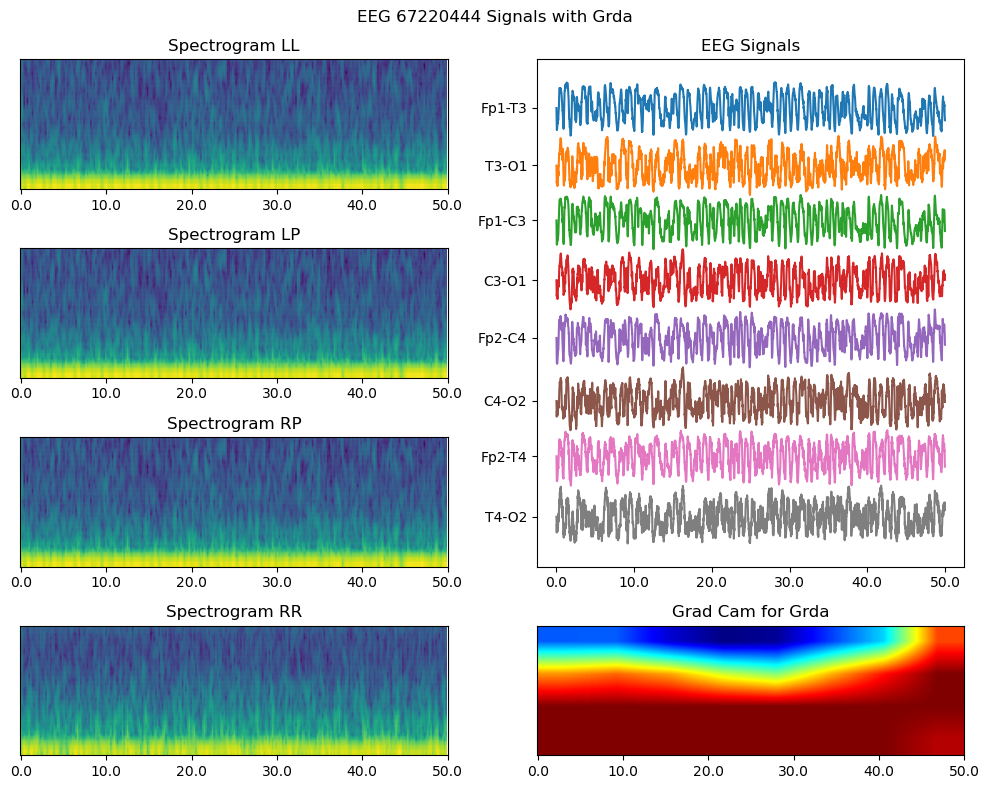

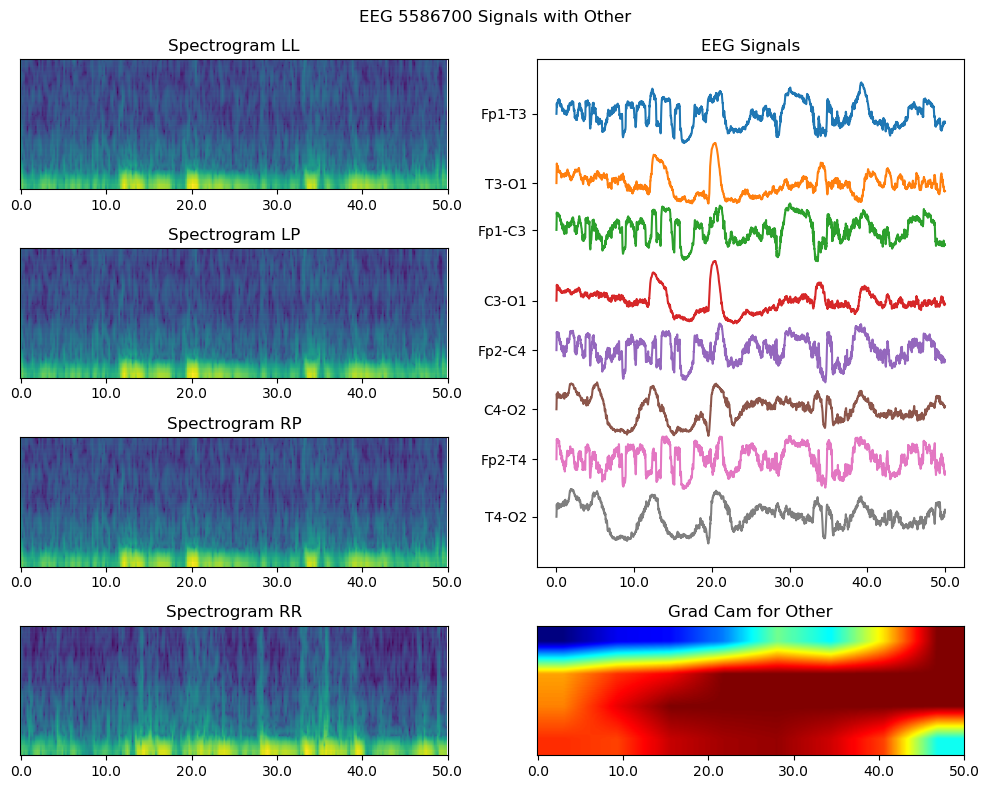

In [12]:
from matplotlib import pyplot as plt


BATCH = 1
TARGETS = Config.TARGETS
NAMES = ['LL','LP','RP','RR']
 
FEATS = BATCH = 1
TARGETS = Config.TARGETS
NAMES = ['LL','LP','RP','RR']
 
FEATS = ['Fp1-T3', 'T3-O1', 'Fp1-C3', 'C3-O1', 'Fp2-C4', 'C4-O2', 'Fp2-T4', 'T4-O2']
for ii,tt in enumerate(TARGETS):
    ttt = tt.split('_')[0].upper()
    
    print()
    print('#'*25)
    print('###',tt.upper())
    print('#'*25)
    
    # FIND TRAIN SAMPLES IN OOF (OUT OF FOLD) WITH TARGET >= 0.5
    base_condition = (oof.fold==fold) & (oof[tt]>= 0.5) & (oof['target'] == name_mapping_inv[ii])
    eeg_ids_new = oof.loc[base_condition, 'eeg_id'].values
    eeg_ids = oof.loc[base_condition & (oof['pred_target'] == ii) & (oof['pred_' + tt] >= 0.4), 'eeg_id'].values
    len_eeg_ids = len(eeg_ids)
    len_eeg_ids_new = len(eeg_ids_new)
    rate = len_eeg_ids/len_eeg_ids_new if len_eeg_ids_new>0 else 0
    print(f'Found {len_eeg_ids}/{len_eeg_ids_new} samples ({rate:.3f}) in fold zero OOF for {tt} with true>0.5')
    
    # # INFER TRAIN SAMPLES WITH MODEL (SAVE PREDS AND ACTIVATIONS)
    df_train = train[~train.eeg_id.isin(eeg_ids)][:BATCH]
    df_valid = train[train.eeg_id.isin(eeg_ids)][:BATCH]
    display(df_valid.head())
    # display(oof[oof.eeg_id.isin(df_valid.eeg_id)])
    _, valid_gen, _ = get_fold_dls(df_train, df_valid, all_eegs, all_spectrograms, EEGDataset)
    print("="*25)
    print("Begin grad cam")
    symptom = tt.split("_")[0].title()
    for batch in valid_gen:
        eeg, spec, _ = batch
        fold_model = model.kfold_models[fold]
        # change the cnn backbone model based on the fold model
        fold_model_cnn_backbone = fold_model.backbone.eeg_spec_net
        grad_cam, cam = get_grad_cam(fold_model, fold_model_cnn_backbone, batch, ii)
        eeg_id = df_valid.eeg_id.values[0]
        plt.figure(figsize=(10, 8))
        for k in range(4):
            plt.subplot2grid((4, 2), (k, 0))
            plt.imshow(spec[0, k],aspect='auto',origin='lower')
            plt.yticks([])
            # set the xticks to be 0 - 50 seconds currently it is 0 to 256
            plt.xticks(np.linspace(0, 256, 6), np.linspace(0, 50, 6))
            plt.title(f'Spectrogram {NAMES[k]}')
        # print(grad_cam.shape)
        plt.subplot2grid((4, 2), (0, 1), rowspan=3)
        offset = 0
        offsets = []
        for j, col in enumerate(FEATS):
            x = eeg[0, j]
            if j!=0: offset += x.max()
            offsets.append(-offset)
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()
        plt.yticks(offsets, FEATS)
        plt.xticks(np.linspace(0, 10_000, 6), np.linspace(0, 50, 6))
        plt.title('EEG Signals')
        plt.subplot2grid((4, 2), (3, 1))
        plt.imshow(grad_cam, aspect='auto', interpolation='bilinear')
        plt.yticks([])
        plt.xticks(np.linspace(0, 256, 6), np.linspace(0, 50, 6))
        plt.title(f'Grad Cam for {symptom}')
        plt.suptitle(f'EEG {eeg_id} Signals with {symptom}')
        plt.tight_layout()
        plt.savefig(f"figures/{eeg_id}_{tt}.png")
        print(); print('#'*25); print()